(516, 5900)
LFP test shape: (516, 2360)
Generating predictions for test set...


100%|██████████| 516/516 [13:19<00:00,  1.55s/it]


Mean of ground truth LFP (after z-scoring): [-1.05012977e-08  1.72230266e-08  3.26385654e-08  2.47177054e-08
  2.59518659e-08  4.00103192e-08  2.83412201e-08  2.58117585e-08
  6.00623882e-09 -6.17179209e-09  3.50775314e-08  2.68488625e-08
 -5.06173597e-09  1.04867025e-08  1.56786436e-08 -1.20725706e-08
 -2.79569417e-08 -4.76167051e-08 -4.06859408e-08 -2.67285883e-08
 -6.61918935e-08 -7.37693744e-08 -6.44061641e-08 -3.20374162e-08
 -6.20938646e-08 -1.18395765e-07 -9.72961363e-08 -1.06712530e-07
 -6.81245466e-08 -1.97057854e-08 -3.49490049e-09 -4.60105581e-09
 -3.92461470e-09 -1.78130409e-08 -4.32067183e-08 -2.59841413e-08
 -1.08552145e-08 -2.01957768e-09 -2.76878307e-08 -2.16501887e-08
 -6.41327780e-08 -6.44359898e-08 -3.40132522e-08  4.83593999e-08
  1.38128654e-07  1.75770603e-07  1.72446153e-07  2.08094456e-07
  1.55193027e-07  1.28389144e-07  4.67345503e-08 -2.13601734e-08
 -1.21560411e-07 -1.60331643e-07 -1.32365911e-07 -1.28158322e-07
 -7.65071680e-08  2.10730793e-08  3.09744705e-

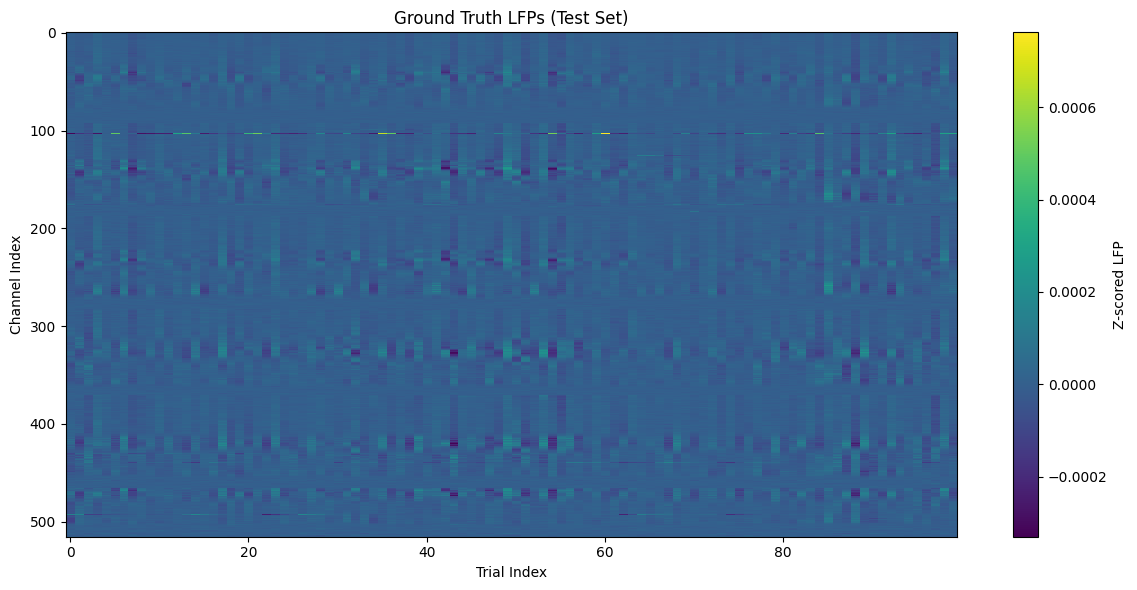

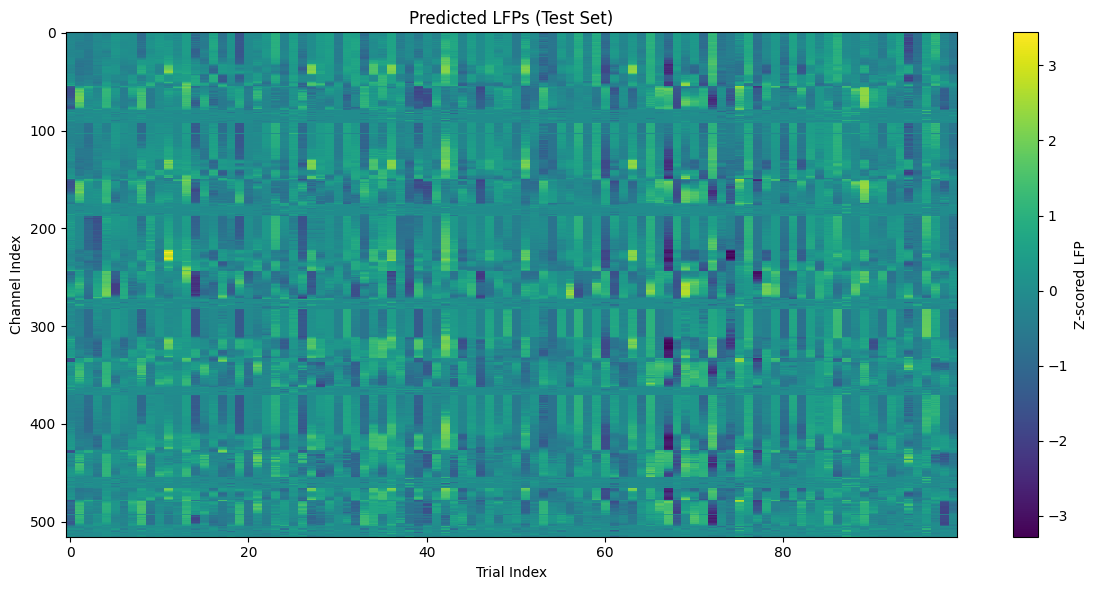

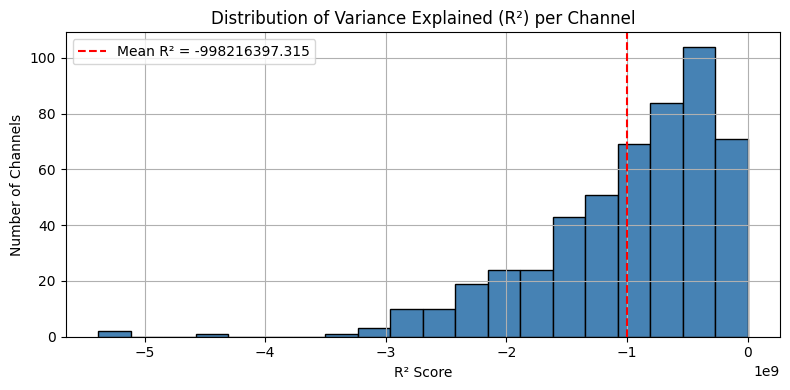

In [10]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dotenv import load_dotenv
# Load environment variables
load_dotenv()

# === Load test data ===
cache_path = os.environ.get("RAINBOW_MOUSE_CACHE")
lfp = np.load(f"{cache_path}/lfp_multi.npy")  
print(lfp.shape)       # [95, 118*50]
frames = np.load(f"{cache_path}/frames_multi.npy") - 1   # [5900], now 0–117
vit_embeddings = np.load(f"{cache_path}/vit_embeddings.npy")  # [118, 192]

# Split train/test
lfp_train = lfp[:, :118*30]
lfp_test = lfp[:, 118*30:]
frames_train = frames[:118*30]
frames_test = frames[118*30:]

eta = 1e-6
nan_mask = np.isnan(lfp_test)

lfp_test[nan_mask] = np.random.normal(loc=0.0, scale=eta, size=nan_mask.sum())

nan_mask = np.isnan(lfp_train)

lfp_train[nan_mask] = np.random.normal(loc=0.0, scale=eta, size=nan_mask.sum())

lfp_train = (lfp_train - np.nanmean(lfp_train, axis=1, keepdims=True)) / np.nanstd(lfp_train, axis=1, keepdims=True)
lfp_test = (lfp_test - np.nanmean(lfp_train, axis=1, keepdims=True)) / np.nanstd(lfp_train, axis=1, keepdims=True)
#lfp_train = (lfp_train - lfp_mean) / lfp_std
#lfp_test = (lfp_test - lfp_mean) / lfp_std

# === Load trained attention model ===
from rainbow_mouse.models.attention_multiprobe import CausalLFPTransformerMulti  # adjust path as needed

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CausalLFPTransformerMulti().to(device)
model.load_state_dict(torch.load(f"{cache_path}/lfp_multi.pth"))
model.eval()

# === Define parameters ===
window_size = model.window_size
half_window = window_size // 2
n_channels, n_trials = lfp_test.shape
print("LFP test shape:", lfp_test.shape)


# === Generate predictions ===
lfp_preds = np.zeros((n_channels, n_trials - window_size + 1))  # output is smaller due to window

print("Generating predictions for test set...")

for channel in tqdm(range(n_channels)):
    for t in range(half_window, n_trials - half_window):
        frame_window = frames_test[t - half_window : t + half_window + 1]  # [window_size]
        vit_window = vit_embeddings[frame_window]                          # [window_size, 192]
        vit_window_tensor = torch.tensor(vit_window, dtype=torch.float32).unsqueeze(0).to(device)  # [1, T, 192]
        channel_tensor = torch.tensor([channel], dtype=torch.long).to(device)

        with torch.no_grad():
            pred = model(vit_window_tensor, channel_tensor).cpu().item()

        lfp_preds[channel, t - half_window] = pred  # adjust index to match reduced output size

# === Plotting ===
def plot_lfp_heatmap(data, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar(label='Z-scored LFP')
    plt.title(title)
    plt.xlabel("Trial Index")
    plt.ylabel("Channel Index")
    plt.tight_layout()
    plt.show()
    
# Clip to same size for visual match
aligned_lfp_test = lfp_test[:, half_window : -half_window]

print("Mean of ground truth LFP (after z-scoring):", aligned_lfp_test.mean(axis=1))
plot_lfp_heatmap(aligned_lfp_test[:, :100], "Ground Truth LFPs (Test Set)")
plot_lfp_heatmap(lfp_preds[:, :100], "Predicted LFPs (Test Set)")

# === Compute variance explained per channel ===
r2_scores = []
for c in range(n_channels):
    y_true = aligned_lfp_test[c]
    y_pred = lfp_preds[c]
    
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    r2_scores.append(r2)

r2_scores = np.array(r2_scores)

# === Plot histogram of R² across channels ===
plt.figure(figsize=(8, 4))
plt.hist(r2_scores, bins=20, color='steelblue', edgecolor='black')
plt.axvline(np.mean(r2_scores), color='red', linestyle='--', label=f"Mean R² = {np.mean(r2_scores):.3f}")
plt.title("Distribution of Variance Explained (R²) per Channel")
plt.xlabel("R² Score")
plt.ylabel("Number of Channels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [15]:
ache_path = os.environ.get("RAINBOW_MOUSE_CACHE")
lfp = np.load(f"{cache_path}/lfp_multi.npy")  
print(lfp.shape)       # [95, 118*50]
frames = np.load(f"{cache_path}/frames_multi.npy") - 1   # [5900], now 0–117
vit_embeddings = np.load(f"{cache_path}/vit_embeddings.npy")  # [118, 192]

# Split train/test
lfp_train = lfp[:, :118*30]
lfp_test = lfp[:, 118*30:]
frames_train = frames[:118*30]
frames_test = frames[118*30:]

eta = 1e-6
nan_mask = np.isnan(lfp_test)

lfp_test[nan_mask] = np.random.normal(loc=0.0, scale=eta, size=nan_mask.sum())

nan_mask = np.isnan(lfp_train)

lfp_train[nan_mask] = np.random.normal(loc=0.0, scale=eta, size=nan_mask.sum())

lfp_test = (lfp_test - np.nanmean(lfp_train, axis=1, keepdims=True)) / np.nanstd(lfp_train, axis=1, keepdims=True)
lfp_test
aligned_lfp_test = lfp_test[:, half_window : -half_window]

(516, 5900)


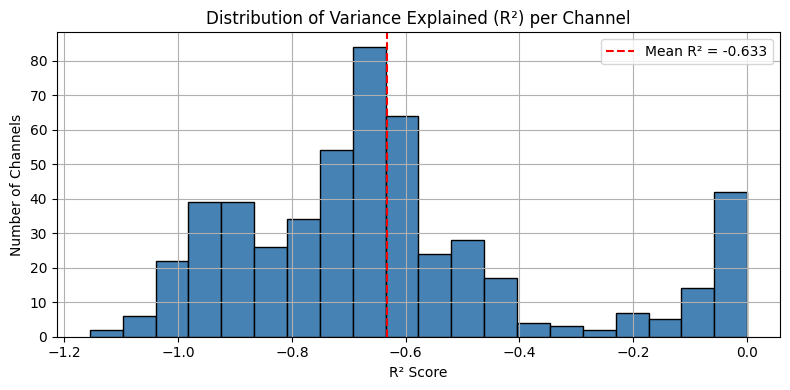

In [16]:
# === Compute variance explained per channel ===
r2_scores = []
for c in range(n_channels):
    y_true = aligned_lfp_test[c]
    y_pred = lfp_preds[c]
    
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    r2_scores.append(r2)

r2_scores = np.array(r2_scores)

# === Plot histogram of R² across channels ===
plt.figure(figsize=(8, 4))
plt.hist(r2_scores, bins=20, color='steelblue', edgecolor='black')
plt.axvline(np.mean(r2_scores), color='red', linestyle='--', label=f"Mean R² = {np.mean(r2_scores):.3f}")
plt.title("Distribution of Variance Explained (R²) per Channel")
plt.xlabel("R² Score")
plt.ylabel("Number of Channels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()